In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import time
from matplotlib import pyplot as plt

# VGGNet的PyTorch复现（猫狗大战）

## 1. 数据集制作

在论文中AlexNet作者使用的是ILSVRC 2012比赛数据集，该数据集非常大（有138G），下载、训练都很消耗时间，我们在复现的时候就不用这个数据集了。由于MNIST、CIFAR10、CIFAR100这些数据集图片尺寸都较小，不符合AlexNet网络输入尺寸227x227的要求，因此我们改用kaggle比赛经典的“猫狗大战”数据集了。

该数据集包含的训练集总共25000张图片，猫狗各12500张，带标签；测试集总共12500张，不带标签。我们仅使用带标签的25000张图片，分别拿出2500张猫和狗的图片作为模型的验证集。我们按照以下目录层级结构，将数据集图片放好。

![](./images/path.png)

为了方便大家训练，我们将该数据集放在百度云盘，下载链接： 链接：https://pan.baidu.com/s/1UEOzxWWMLCUoLTxdWUkB4A 提取码：cdue

### 1.1 制作图片数据的索引

准备好数据集之后，我们需要用PyTorch来读取并制作可以用来训练和测试的数据集。对于训练集和测试集，首先要分别制作对应的图片数据索引，即train.txt和test.txt两个文件，每个txt中包含每个图片的目录和对应类别class（cat对应的label=0，dog对应的label=1）。示意图如下：

![](./images/index.png)

制作图片数据索引train.txt和test.txt两个文件的python脚本程序如下：

In [24]:
import os

train_txt_path = os.path.join("data", "catVSdog", "train.txt")
train_dir = os.path.join("data", "catVSdog", "train_data")
valid_txt_path = os.path.join("data", "catVSdog", "test.txt")
valid_dir = os.path.join("data", "catVSdog", "test_data")

def gen_txt(txt_path, img_dir):
    f = open(txt_path, 'w')
    
    for root, s_dirs, _ in os.walk(img_dir, topdown=True):  # 获取 train文件下各文件夹名称
        for sub_dir in s_dirs:
            i_dir = os.path.join(root, sub_dir)             # 获取各类的文件夹 绝对路径
            img_list = os.listdir(i_dir)                    # 获取类别文件夹下所有png图片的路径
            for i in range(len(img_list)):
                if not img_list[i].endswith('jpg'):         # 若不是png文件，跳过
                    continue
                #label = (img_list[i].split('.')[0] == 'cat')? 0 : 1 
                label = img_list[i].split('.')[0]
                # 将字符类别转为整型类型表示
                if label == 'cat':
                    label = '0'
                else:
                    label = '1'
                img_path = os.path.join(i_dir, img_list[i])
                line = img_path + ' ' + label + '\n'
                f.write(line)
    f.close()

if __name__ == '__main__':
    gen_txt(train_txt_path, train_dir)
    gen_txt(valid_txt_path, valid_dir)

运行脚本之后就在./data/catVSdog/目录下生成train.txt和test.txt两个索引文件。

### 1.2 构建Dataset子类

PyTorch 加载自己的数据集，需要写一个继承自torch.utils.data中Dataset类，并修改其中的__init__方法、__getitem__方法、__len__方法。默认加载的都是图片，__init__的目的是得到一个包含数据和标签的list，每个元素能找到图片位置和其对应标签。然后用__getitem__方法得到每个元素的图像像素矩阵和标签，返回img和label。

In [25]:
from PIL import Image
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, txt_path, transform = None, target_transform = None):
        fh = open(txt_path, 'r')
        imgs = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0], int(words[1]))) # 类别转为整型int
            self.imgs = imgs 
            self.transform = transform
            self.target_transform = target_transform
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = Image.open(fn).convert('RGB') 
        #img = Image.open(fn)
        if self.transform is not None:
            img = self.transform(img) 
        return img, label
    def __len__(self):
        return len(self.imgs)

getitem是核心函数。self.imgs是一个list，self.imgs[index]是一个str，包含图片路径，图片标签，这些信息是从上面生成的txt文件中读取；利用Image.open对图片进行读取，注意这里的img是单通道还是三通道的；self.transform(img)对图片进行处理，这个transform里边可以实现减均值、除标准差、随机裁剪、旋转、翻转、放射变换等操作。

### 1.3 加载数据集和数据预处理

当Mydataset构建好，剩下的操作就交给DataLoder来加载数据集。在DataLoder中，会触发Mydataset中的getiterm函数读取一张图片的数据和标签，并拼接成一个batch返回，作为模型真正的输入。

In [26]:
pipline_train = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  #随机旋转图片
    #将图片尺寸resize到224x224
    transforms.Resize((224,224)),
    #将图片转化为Tensor格式
    transforms.ToTensor(),
    #正则化(当模型出现过拟合的情况时，用来降低模型的复杂度)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])
pipline_test = transforms.Compose([
    #将图片尺寸resize到224x224
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])
train_data = MyDataset('./data/catVSdog/train.txt', transform=pipline_train)
test_data = MyDataset('./data/catVSdog/test.txt', transform=pipline_test)

#train_data 和test_data包含多有的训练与测试数据，调用DataLoader批量加载
trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)
# 类别信息也是需要我们给定的
classes = ('cat', 'dog') # 对应label=0，label=1

在数据预处理中，我们将图片尺寸调整到224x224，符合VGGNet网络的输入要求。均值mean = [0.5, 0.5, 0.5]，方差std = [0.5, 0.5, 0.5]，然后使用transforms.Normalize进行归一化操作。

我们来看一下最终制作的数据集图片和它们对应的标签：

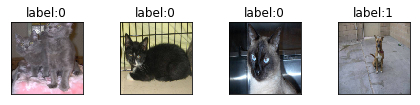

In [27]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_label) = next(examples)
# 批量展示图片
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.tight_layout()  #自动调整子图参数，使之填充整个图像区域
    img = example_data[i]
    img = img.numpy() # FloatTensor转为ndarray
    img = np.transpose(img, (1,2,0)) # 把channel那一维放到最后
    img = img * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5]
    #img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    plt.imshow(img)
    plt.title("label:{}".format(example_label[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## 搭建VGGNet神经网络结构

In [28]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=2, init_weights=False):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 500),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(500, 20),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(20, num_classes)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.features(x)
        # N x 512 x 7 x 7
        x = torch.flatten(x, start_dim=1)
        # N x 512*7*7
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_features(cfg: list):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg(model_name="vgg16", **kwargs):
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    cfg = cfgs[model_name]

    model = VGG(make_features(cfg), **kwargs)
    return model

首先，我们从VGG 6个结构中选择了A、B、D、E这四个来搭建模型，建立的cfg字典包含了这4个结构。例如对于vgg16，`[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']`表示了卷积层的结构。64表示conv3-64，'M'表示maxpool，128表示conv3-128，256表示conv3-256，512表示conv3-512。

![](./images/vgg.jpg)

选定好哪个VGG结构之后，将该列表传入到函数make_features()中，构建VGG的卷积层，函数返回实例化模型。例如我们来构建vgg16的卷积层结构并打印看看：

In [29]:
cfg = cfgs['vgg16']
make_features(cfg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

定义VGG类的时候，参数num_classes指的是类别的数量，由于我们这里的数据集只有猫和狗两个类别，因此这里的全连接层的神经元个数做了微调。num_classes=2，输出层也是两个神经元，不是原来的1000个神经元。FC4096由原来的4096个神经元分别改为500、20个神经元。这里的改动大家注意一下，根据实际数据集的类别数量进行调整。整个网络的其它结构跟论文中的完全一样。

函数initialize_weights()是对网络参数进行初始化操作，这里我们默认选择关闭初始化操作。

函数forward()定义了VGG网络的完整结构，这里注意最后的卷积层输出的featureMap是N x 512 x 7 x 7，N表示batchsize，需要将其展开为一维向量，方便与全连接层连接。

## 3. 将定义好的网络结构搭载到GPU/CPU，并定义优化器

In [30]:
#创建模型，部署gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "vgg16"
model = vgg(model_name=model_name, num_classes=2, init_weights=True)
model.to(device)
#定义优化器
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## 4. 定义训练过程

In [31]:
def train_runner(model, device, trainloader, loss_function, optimizer, epoch):
    #训练模型, 启用 BatchNormalization 和 Dropout, 将BatchNormalization和Dropout置为True
    model.train()
    total = 0
    correct =0.0
    
    #enumerate迭代已加载的数据集,同时获取数据和数据下标
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #把模型部署到device上
        inputs, labels = inputs.to(device), labels.to(device)
        #初始化梯度
        optimizer.zero_grad()
        #保存训练结果
        outputs = model(inputs)
        #计算损失和
        #loss = F.cross_entropy(outputs, labels)
        loss = loss_function(outputs, labels)
        #获取最大概率的预测结果
        #dim=1表示返回每一行的最大值对应的列下标
        predict = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
        if i % 100 == 0:
            #loss.item()表示当前loss的数值
            print("Train Epoch{} \t Loss: {:.6f}, accuracy: {:.6f}%".format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)
    return loss.item(), correct/total

## 5. 定义测试过程

In [32]:
def test_runner(model, device, testloader):
    #模型验证, 必须要写, 否则只要有输入数据, 即使不训练, 它也会改变权值
    #因为调用eval()将不启用 BatchNormalization 和 Dropout, BatchNormalization和Dropout置为False
    model.eval()
    #统计模型正确率, 设置初始值
    correct = 0.0
    test_loss = 0.0
    total = 0
    #torch.no_grad将不会计算梯度, 也不会进行反向传播
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            #计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()
        #计算损失值
        print("test_avarage_loss: {:.6f}, accuracy: {:.6f}%".format(test_loss/total, 100*(correct/total)))

## 6. 运行

start_time 2022-02-11 16:01:00
Train Epoch1 	 Loss: 0.692880, accuracy: 54.687500%
Train Epoch1 	 Loss: 0.693360, accuracy: 51.129332%
Train Epoch1 	 Loss: 0.692834, accuracy: 50.412002%
Train Epoch1 	 Loss: 0.693534, accuracy: 50.394518%
test_avarage_loss: 0.021764, accuracy: 50.000000%
end_time:  2022-02-11 16:04:28 

start_time 2022-02-11 16:04:28
Train Epoch2 	 Loss: 0.691072, accuracy: 62.500000%
Train Epoch2 	 Loss: 0.693356, accuracy: 49.489480%
Train Epoch2 	 Loss: 0.693212, accuracy: 49.790112%
Train Epoch2 	 Loss: 0.692290, accuracy: 49.916944%
test_avarage_loss: 0.021765, accuracy: 50.000000%
end_time:  2022-02-11 16:07:56 

start_time 2022-02-11 16:07:56
Train Epoch3 	 Loss: 0.692666, accuracy: 48.437500%
Train Epoch3 	 Loss: 0.692639, accuracy: 50.293936%
Train Epoch3 	 Loss: 0.691348, accuracy: 50.396455%
Train Epoch3 	 Loss: 0.689182, accuracy: 50.913621%
test_avarage_loss: 0.021766, accuracy: 50.000000%
end_time:  2022-02-11 16:11:23 

start_time 2022-02-11 16:11:23
Tra

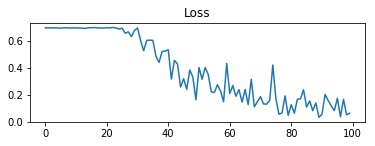

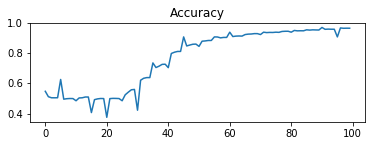

In [33]:
#调用
epoch = 20
Loss = []
Accuracy = []
for epoch in range(1, epoch+1):
    print("start_time",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
    loss, acc = train_runner(model, device, trainloader, loss_function, optimizer, epoch)
    Loss.append(loss)
    Accuracy.append(acc)
    test_runner(model, device, testloader)
    print("end_time: ",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'\n')

print('Finished Training')
plt.subplot(2,1,1)
plt.plot(Loss)
plt.title('Loss')
plt.show()
plt.subplot(2,1,2)
plt.plot(Accuracy)
plt.title('Accuracy')
plt.show()

## 7. 保存模型

In [34]:
print(model)
torch.save(model, './models/vgg-catvsdog.pth') #保存模型

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

/home/jysp/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type VGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## 8. 模型测试

下面使用一张猫狗大战测试集的图片进行模型的测试。

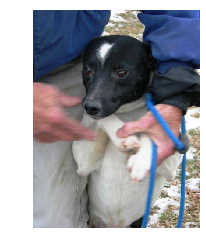

概率： tensor([[7.6922e-08, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>)
预测类别： dog


In [36]:
from PIL import Image
import numpy as np

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load('./models/vgg-catvsdog.pth') #加载模型
    model = model.to(device)
    model.eval()    #把模型转为test模式
    
    #读取要预测的图片
    # 读取要预测的图片
    img = Image.open("./images/test_dog.jpg") # 读取图像
    #img.show()
    plt.imshow(img) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
    # 导入图片，图片扩展后为[1，1，32，32]
    trans = transforms.Compose(
        [
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            #transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        ])
    img = trans(img)
    img = img.to(device)
    img = img.unsqueeze(0)  #图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
    
    # 预测 
    # 预测 
    classes = ('cat', 'dog')
    output = model(img)
    prob = F.softmax(output,dim=1) #prob是2个分类的概率
    print("概率：",prob)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    pred_class = classes[predicted.item()]
    print("预测类别：",pred_class)